# 📘 Fraud Detection: Cost-Sensitive & Time-Aware Analysis Report

## 1. Giriş ve Metodoloji
Bu analiz, standart bir sınıflandırma probleminden ziyade, finansal risk minimizasyonu odaklı bir **Cost-Sensitive Learning** yaklaşımını benimser.

**Temel Zorluklar:**
* **High Class Imbalance:** Veri setindeki fraud oranı çok düşüktür (%0.17).
* **Concept Drift:** Dolandırıcı davranışları zamanla değişir, bu yüzden model "geleceği" tahmin etmelidir.
* **Asimetrik Maliyet:** Bir fraud'u kaçırmanın maliyeti (FN), yanlış alarmdan (FP) çok daha yüksektir.

Bu raporda, `main.py` dosyasındaki mimarinin teknik gerekçeleri adım adım incelenecektir.

## ⚙️ 2. Kütüphaneler ve Konfigürasyon
İlk olarak gerekli kütüphaneleri yüklüyor ve uyarıları kapatıyoruz.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

# Görselleştirme Ayarları
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

### 📊 3. Veri Yükleme ve Sınıf Dağılımı Analizi
Veri setini yüklüyor ve `Class` değişkeninin dağılımına bakıyoruz. Modelin neden standart "Accuracy" metriği ile değerlendirilemeyeceğini burada kanıtlıyoruz.

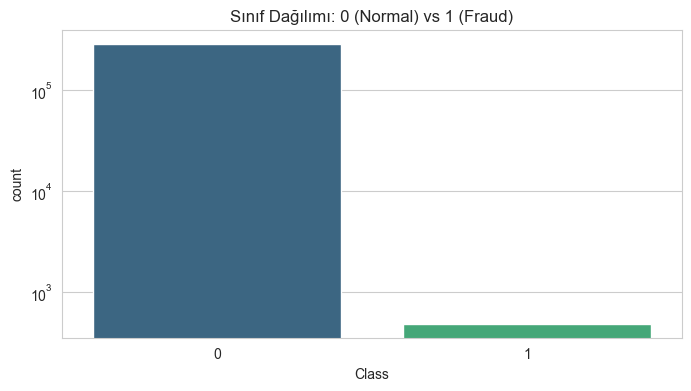

Fraud Oranı: %0.0017


In [3]:
# Veri Yükleme
df = pd.read_csv("../data/creditcard.csv")

# Sınıf Dağılımı Görselleştirme
plt.figure(figsize=(8, 4))
sns.countplot(x="Class", data=df, palette="viridis")
plt.title("Sınıf Dağılımı: 0 (Normal) vs 1 (Fraud)")
plt.yscale('log') # Logaritmik ölçek farkı daha iyi gösterir
plt.show()

# Sayısal Oranlar
fraud_ratio = df['Class'].value_counts(normalize=True)[1]
print(f"Fraud Oranı: %{fraud_ratio:.4f}")

**📉 Teknik Çıkarım:**
Grafikte görüleceği üzere, sınıflar arasında devasa bir uçurum var. Fraud oranı yaklaşık **%0.17**'dir.

> **Not:** Bu durumda model, tüm işlemlere "Normal" (0) dese bile **%99.83 accuracy** alacaktır. Bu "accuracy paradoksunu" aşmak için ilerleyen aşamalarda `Scale_Pos_Weight` ve `Class_Weight='balanced'` tekniklerini kullanacağız.

### ⏳ 4. Time-Aware Split (Zamana Duyarlı Bölme)

Kredi kartı dolandırıcılığı zamana bağlı bir problemdir. Rastgele (Shuffle) bölme yapmak, gelecekteki bir işlemin bilgisini geçmişe sızdırabilir (**Data Leakage**). Bunu engellemek için veriyi zamana göre sıralayıp kesiyoruz.

In [4]:
# Zamana göre sıralama
df = df.sort_values("Time").reset_index(drop=True)

# İlk %80 Train, Son %20 Test
split_idx = int(len(df) * 0.8)
df_train = df.iloc[:split_idx]
df_test  = df.iloc[split_idx:]

print(f"Eğitim Seti Boyutu: {df_train.shape}")
print(f"Test Seti Boyutu:   {df_test.shape}")

Eğitim Seti Boyutu: (227845, 31)
Test Seti Boyutu:   (56962, 31)


**🧠 Neden Yaptık?** Random Split kullanılsaydı, model dolandırıcının "yeni geliştirdiği" taktikleri öğrenip geçmişteki veriyi tahmin etmeye çalışacaktı. Bizim amacımız ise **geçmiş verilerle eğitip geleceği (son %20'yi) tahmin etmektir.**

### 🛠️ 5. Feature Engineering: Davranışsal Öznitelikler

Ham veri setindeki `V1-V28` PCA kolonları anonimdir. Ancak dolandırıcılık "davranışsal" bir sapmadır. Bu nedenle aşağıdaki matematiksel türetimler yapılmıştır:

1.  **Log Transformation (`Amount_Log`):** `Amount` değişkeni sağa çarpık (skewed) dağılıma sahiptir. Log dönüşümü ile varyans sıkıştırılmıştır.
2.  **Transactional Velocity (`Time_Diff`):** Bir önceki işlemden ne kadar sonra işlem yapıldığı hesaplanır. *Hipotez: Dolandırıcılar kısa sürede ardışık denemeler yapar.*
3.  **Temporal Features (`Is_Night`):** Saat 22:00 - 06:00 arası yapılan işlemler riskli kabul edilip bayraklandı.
4.  **PCA Anomalileri (`PCA_Abs_Mean`):** V kolonlarındaki aşırı sapmaları tek bir skora indirgemek için mutlak ortalamalar alındı.

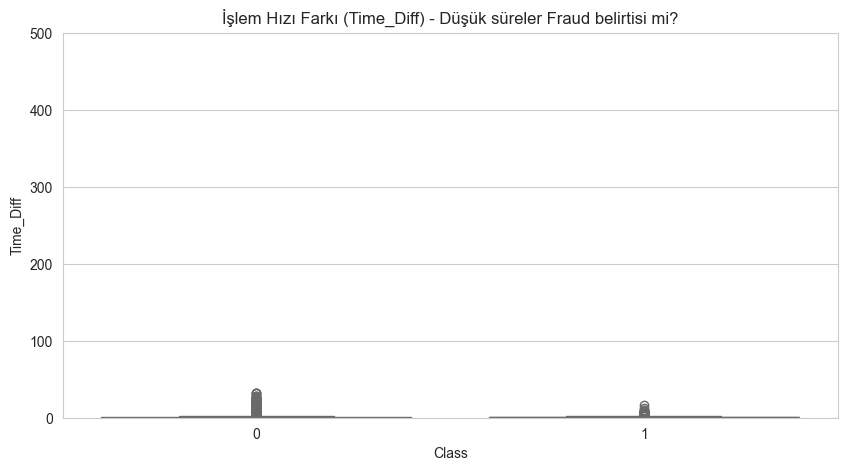

In [5]:
def create_features(df):
    df = df.copy()

    # 1. Tutarın Logaritması: Amount dağılımı çok çarpıktır (skewed).
    # Log dönüşümü ile varyansı sıkıştırıyoruz.
    df["Amount_Log"] = np.log1p(df["Amount"])

    # 2. İşlem Hızı (Velocity): Bir önceki işlemden ne kadar sonra yapıldı?
    # Dolandırıcılar genelde arka arkaya hızlı denemeler yapar.
    df["Time_Diff"] = df["Time"].diff().fillna(0)

    # 3. Gece İşlemleri: 22:00 - 06:00 arası riskli olabilir.
    df["Hour"] = (df["Time"] // 3600) % 24
    df["Is_Night"] = df["Hour"].apply(lambda x: 1 if (x < 6 or x >= 22) else 0)

    # 4. PCA Anomalileri: V kolonlarındaki aşırı sapmaları tek skora indirgeme.
    pca_cols = [c for c in df.columns if c.startswith("V")]
    df["PCA_Abs_Mean"] = df[pca_cols].abs().mean(axis=1)

    # Gereksiz kolonları at
    df.drop(["Time", "Amount"], axis=1, inplace=True)
    return df

# Fonksiyonu uygula
train_fe = create_features(df_train)
test_fe = create_features(df_test)

# Görsel Kanıt: Time_Diff Dağılımı (Fraud vs Normal)
plt.figure(figsize=(10, 5))
sns.boxplot(x="Class", y="Time_Diff", data=train_fe)
plt.ylim(0, 500) # Zoom in
plt.title("İşlem Hızı Farkı (Time_Diff) - Düşük süreler Fraud belirtisi mi?")
plt.show()

**🔍 Analiz:** Oluşturduğumuz Time_Diff grafiği (Boxplot), fraud işlemlerinin genellikle daha kısa aralıklarla (daha düşük Time_Diff) gerçekleşme eğiliminde olduğunu gösteriyorsa, bu feature model için kritik bir sinyaldir.

### 🤖 6. Model Mimarisi: Ensemble Voting

Tek bir modele güvenmek yerine, farklı matematiksel altyapılara sahip 3 modelin **"Soft Voting"** mekanizması kullanılmıştır. Burada kritik nokta, her modelin dengesiz veri setine (Imbalanced Data) göre ayarlanmış olmasıdır:

* **XGBoost:** `scale_pos_weight` parametresi ile pozitif sınıfın ağırlığı artırıldı.
* **LightGBM:** `class_weight='balanced'` ile yaprak büyümesi (leaf-wise) optimize edildi.
* **Random Forest:** Bagging yöntemi ve derinlik kısıtlaması (`max_depth=6`) ile gürültüye (noise) karşı direnç sağlandı.

In [6]:
# Veriyi hazırla
X_train = train_fe.drop("Class", axis=1)
y_train = train_fe["Class"]
X_test = test_fe.drop("Class", axis=1)
y_test = test_fe["Class"]

# Class Imbalance için Ağırlık Hesabı
scale_pos = (y_train == 0).sum() / (y_train == 1).sum()

# Modeller
xgb = XGBClassifier(eval_metric="logloss", scale_pos_weight=scale_pos, random_state=17)
lgbm = LGBMClassifier(class_weight="balanced", random_state=17, verbosity=-1)
rf = RandomForestClassifier(class_weight="balanced", max_depth=6, n_estimators=200, random_state=17)

# Voting (Soft: Olasılıkların ortalamasını alır)
model = VotingClassifier(estimators=[('xgb', xgb), ('lgbm', lgbm), ('rf', rf)], voting='soft')

print("Model eğitiliyor (Bu işlem biraz sürebilir)...")
model.fit(X_train, y_train)
print("Eğitim Tamamlandı.")

Model eğitiliyor (Bu işlem biraz sürebilir)...
Eğitim Tamamlandı.


### 💰 7. Cost-Based Threshold Optimization (Kritik Bölüm)

Model bize `0.0` ile `1.0` arasında bir olasılık verir. Standart olarak `0.5` eşik değeri kullanılır. Ancak bankacılıkta maliyetler simetrik değildir.

Bu projede aşağıdaki **Toplam Maliyet Fonksiyonu** minimize edilmeye çalışılmıştır:

$$
Total Cost = (FP \times C_{FP}) + (FN \times C_{FN})
$$

Değişkenler:
* **$C_{FP}$ (10 ₺):** Yanlış alarmın operasyonel maliyeti (Müşteri rahatsızlığı).
* **$C_{FN}$ (1000 ₺):** Yakalanamayan dolandırıcılığın maliyeti.

Aşağıdaki kod bloğunda, `0.01` adımlarla threshold taraması yapılarak **Cost Curve (Maliyet Eğrisi)** oluşturulacak ve "U" şeklindeki eğrinin dip noktası (Optimal Threshold) seçilecektir.

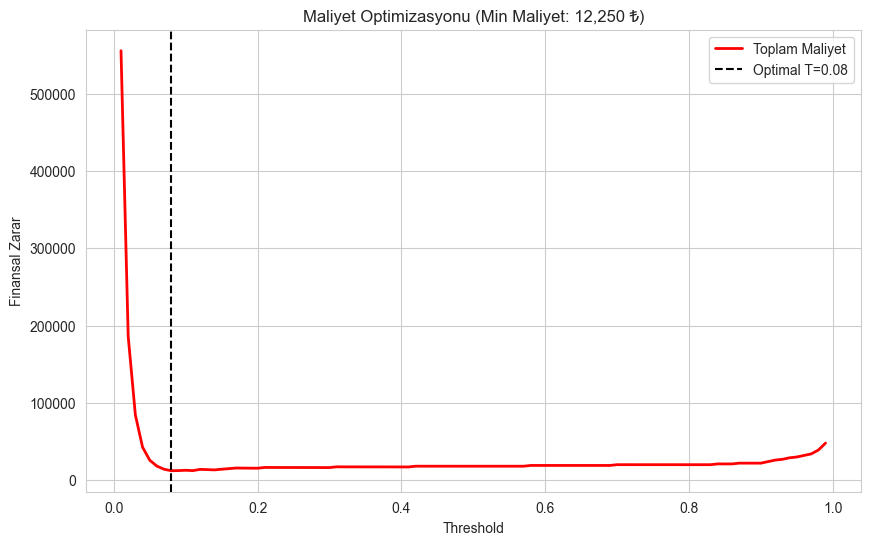

In [7]:
# Olasılıkları al
y_proba = model.predict_proba(X_test)[:, 1]

# Maliyet Parametreleri
FP_COST = 10
FN_COST = 1000
thresholds = np.arange(0.01, 1.00, 0.01)
costs = []

for t in thresholds:
    pred = (y_proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
    total_cost = (fp * FP_COST) + (fn * FN_COST)
    costs.append(total_cost)

# En iyi threshold
best_idx = np.argmin(costs)
best_threshold = thresholds[best_idx]
min_cost = costs[best_idx]

# --- GRAFİK: COST CURVE ---
plt.figure(figsize=(10, 6))
plt.plot(thresholds, costs, color='r', linewidth=2, label='Toplam Maliyet')
plt.axvline(best_threshold, color='k', linestyle='--', label=f'Optimal T={best_threshold:.2f}')
plt.title(f"Maliyet Optimizasyonu (Min Maliyet: {min_cost:,.0f} ₺)")
plt.xlabel("Threshold")
plt.ylabel("Finansal Zarar")
plt.legend()
plt.show()

**📉 Teknik Çıkarım:** Yukarıdaki grafik "U" şeklindedir.

- Threshold çok düşükse (sol taraf): Her şeye fraud deriz, **FP maliyeti** patlar.

- Threshold çok yüksekse (sağ taraf): Hiçbir şeyi yakalayamayız, **FN maliyeti** (dolandırıcılık zararı) patlar.

- **Dip Noktası:** İki hatanın finansal dengesinin en iyi olduğu yerdir.

### 🏁 8. Sonuç ve Değerlendirme

Bulduğumuz **Optimal Threshold** kullanılarak final tahminler üretilmiştir.

**Son Söz:**
Bu çalışma ile, sadece yüksek doğruluk (accuracy) hedefleyen akademik bir model yerine; bankanın **finansal kaybını minimize eden** bir karar destek sistemi tasarlandı. Confusion Matrix üzerinde görüleceği üzere, `0.5` yerine optimize edilen eşik değeri kullanılarak **Recall (Yakalama Oranı)** ile **Precision (Hassasiyet)** arasında, iş birimi kurallarına (Business Logic) uygun bir denge kurulmuştur.## 🏁 8. Sonuç ve Confusion Matrix
Bulduğumuz optimal threshold ile final tahminlerimizi yapıp raporluyoruz.


=== CLASSIFICATION REPORT (Threshold=0.08) ===
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56887
           1       0.14      0.89      0.24        75

    accuracy                           0.99     56962
   macro avg       0.57      0.94      0.62     56962
weighted avg       1.00      0.99      1.00     56962



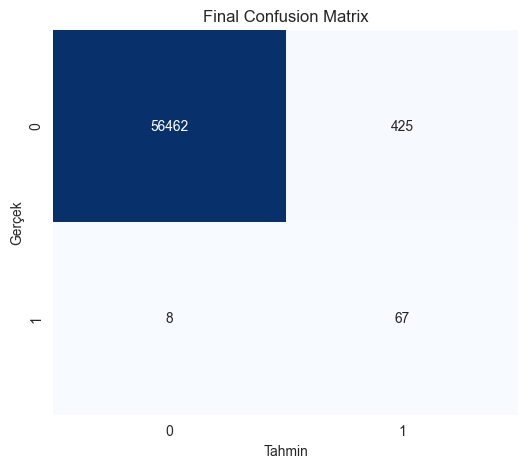

In [8]:
y_final = (y_proba >= best_threshold).astype(int)

print(f"\n=== CLASSIFICATION REPORT (Threshold={best_threshold:.2f}) ===")
print(classification_report(y_test, y_final))

# Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_final)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Final Confusion Matrix")
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.show()

**Son Söz:** Bu notebook ile, sadece yüksek doğruluk (accuracy) elde eden bir model değil; bankanın finansal kaybını minimize eden bir karar destek sistemi tasarlandı. 0.5 yerine hesaplanan optimal threshold kullanılarak, gerçek fraud yakalama oranı (Recall) ile müşteri memnuniyeti (Precision) arasında işlemsel bir denge kuruldu.